# Features comparison

In [29]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()
import scipy
from scipy import stats
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [27]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'AAPL'
price_column = 'Close'

predict_n = 1
NORMALIZE_FEATURES = True

In [6]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=NORMALIZE_FEATURES)

data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,0.001741,0.001969,0.002107,0.002934,0.337769,0.002524,0.000078,0.597417,0.000317,...,0.000023,0.000000,0.000000,0.445527,0.531663,0.516652,0.683788,higher,0.003017,higher
1,2007-02-22,0.003014,0.002316,0.002805,0.003017,0.243081,0.002595,0.003813,0.608719,0.006346,...,0.000117,0.000040,0.000135,0.445232,0.531187,0.511465,0.573995,higher,0.002899,lower
2,2007-02-23,0.002581,0.002192,0.002891,0.002899,0.147424,0.002494,0.000856,0.582323,0.001388,...,0.000197,0.000081,0.000236,0.443849,0.530828,0.510164,0.547628,lower,0.002750,lower
3,2007-02-26,0.002760,0.002103,0.002555,0.002750,0.176675,0.002365,0.003501,0.548723,0.003054,...,0.000343,0.000126,0.000302,0.442470,0.529935,0.509956,0.543318,lower,0.001528,lower
4,2007-02-27,0.001825,0.001335,0.001414,0.001528,0.334932,0.001315,0.002023,0.340556,0.008765,...,0.000317,0.000097,0.000187,0.435232,0.529921,0.502983,0.400476,lower,0.001710,higher


In [9]:
feature_names = data_wrapper.feature_names

In [10]:
def compute_t_test_classes(df, feature_names, classes, class_column='Next', equal_var=False):
    feature_p_vals = {}
    for feature in feature_names:
        # get the filtered series with only the feature, filtered by the target class
        a = df[df[class_column] == classes[0]][feature]
        b = df[df[class_column] == classes[1]][feature]


        t_stat, p_computed = stats.ttest_ind(a, b, equal_var = equal_var)
        feature_p_vals[feature] = p_computed
            
    # return the dictionary sorted by p_value (ASC)
    return {k: v if not np.isnan(v) else 1.0 for k, v in sorted(feature_p_vals.items(), key=lambda item: item[1])}

classes = list(data_wrapper['Next'].value_counts().to_dict().keys())
test_feature_names = feature_names + ['Volume', 'Close']
test_feature_names = [feature for feature in test_feature_names if feature not in ['Next','Tendency']] 

feature_p_vals = compute_t_test_classes(data_wrapper.df, test_feature_names, classes)

{'Difference': 0.005710653131745634, 'LowLen': 0.029777583894247988, 'PercentageDiff': 0.042758247736372004, 'RSI(14)': 0.049292691974490405, 'StochOsc': 0.11951510702082875, 'MACD': 0.149470394062107, 'RSI_diff': 0.169472888255546, 'MACD_signal': 0.17430603992094057, 'SMA(20) - SMA(10)': 0.20728195615591505, 'BG_H_Band_Indicator': 0.23862888054845782, 'GAP': 0.24238323829046382, 'ROC': 0.24296998015773869, 'Volume_diff': 0.2580783304216162, 'NextPrice': 0.3920942540615099, 'MACD_diff': 0.5637080490407425, 'Volume': 0.5658823701616722, 'BG_L_Band_Indicator': 0.7156366428232789, 'EMA_Diff': 0.8934670702089287, 'BG_H_Band': 0.9098910055682975, 'SMA(20)': 0.9273372099967642, 'BodyLen': 0.9451284898414347, 'BG_L_Band': 0.947820124721177, 'EMA(14)': 0.9537837145833891, 'Close': 0.9603171416661713, 'SMA(10)': 0.968107065378472}


In [26]:
print("Feature p-values (lower is better):\n")
for feature, val in feature_p_vals.items():
    print(f"[{feature}] -> {100*val:.2f} %")

Feature p-values (lower is better):

[Difference] -> 0.57 %
[LowLen] -> 2.98 %
[PercentageDiff] -> 4.28 %
[RSI(14)] -> 4.93 %
[StochOsc] -> 11.95 %
[MACD] -> 14.95 %
[RSI_diff] -> 16.95 %
[MACD_signal] -> 17.43 %
[SMA(20) - SMA(10)] -> 20.73 %
[BG_H_Band_Indicator] -> 23.86 %
[GAP] -> 24.24 %
[ROC] -> 24.30 %
[Volume_diff] -> 25.81 %
[NextPrice] -> 39.21 %
[MACD_diff] -> 56.37 %
[Volume] -> 56.59 %
[BG_L_Band_Indicator] -> 71.56 %
[EMA_Diff] -> 89.35 %
[BG_H_Band] -> 90.99 %
[SMA(20)] -> 92.73 %
[BodyLen] -> 94.51 %
[BG_L_Band] -> 94.78 %
[EMA(14)] -> 95.38 %
[Close] -> 96.03 %
[SMA(10)] -> 96.81 %


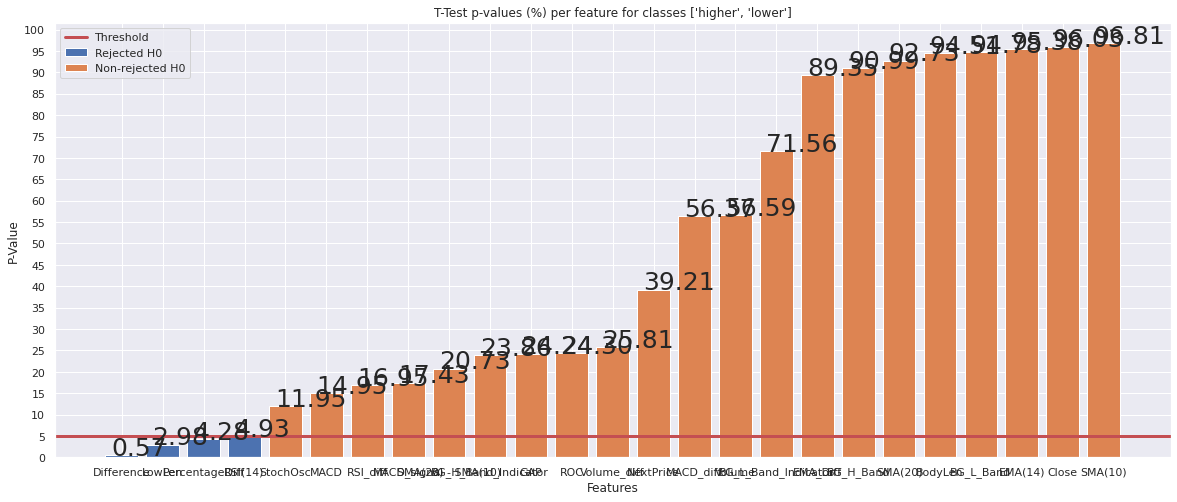

In [11]:
P_THRESH = 0.05


lowers = [(label, val) for label, val in feature_p_vals.items() if val <= P_THRESH]
highers = [(label, val) for label, val in feature_p_vals.items() if val > P_THRESH]


plt.bar([t[0] for t in lowers], [t[1]*100 for t in lowers], label="Rejected H0") 
plt.bar([t[0] for t in highers], [t[1]*100 for t in highers], label="Non-rejected H0")


x_locs, _ = plt.xticks()
for i, value in enumerate([x*100 for x in feature_p_vals.values()]):
    plt.text(x_locs[i] - 0.25, value + 0.01, f"{value:.2f}")
    
plt.axhline(y = P_THRESH * 100, color = 'r', linestyle = '-', linewidth=3.0, label="Threshold")
plt.yticks(np.arange(0, 101, step=5))
plt.title(f"T-Test p-values (%) per feature for classes {classes}")
plt.legend(loc='best')
plt.xlabel('Features')
plt.ylabel('P-Value')
plt.show()

In [30]:
df_dict = StocksDataWrapper.import_folder(DATA_PATH, files_pattern="*.txt", compute_features=True, normalize=NORMALIZE_FEATURES)

higher_features_dict = {k:0 for k,v in feature_p_vals.items()}
lower_features_dict = {k:0 for k,v in feature_p_vals.items()}

# for each dataset given count the times where the features was higher or lower than the threshold
for (dataset, label) in tqdm(df_dict.items()):
    df = dataset.df
    feature_p_vals = compute_t_test_classes(df, test_feature_names, classes)
    for k,v in feature_p_vals.items():
        try:
            if v > P_THRESH:
                higher_features_dict[k] += 1
            else:
                lower_features_dict[k] += 1
        except KeyError as e:
            print(f"Some key was filtered from the ")

  0%|          | 0/11 [00:00<?, ?it/s]

In [31]:
df = pd.DataFrame(list(lower_features_dict.items()), columns=['Feature','Lower'])
# add the sum for the plot
df['Lower_Ratio'] = df['Lower'].apply(lambda x: float(x) / len(df_dict))
df['Sum'] = pd.Series(1.0 for val in zip(higher_features_dict.values(), lower_features_dict.values()))
df = df.sort_values(by='Lower', ascending=False)
df.loc[:, ['Feature', 'Lower_Ratio']]

,Feature,Lower_Ratio
2,PercentageDiff,0.636364
0,Difference,0.545455
13,NextPrice,0.545455
3,RSI(14),0.272727
4,StochOsc,0.272727
6,RSI_diff,0.272727
1,LowLen,0.272727
15,Volume,0.272727
22,EMA(14),0.181818
21,BG_L_Band,0.181818


In [52]:
#df.to_csv('features_comparison.csv', index=False)

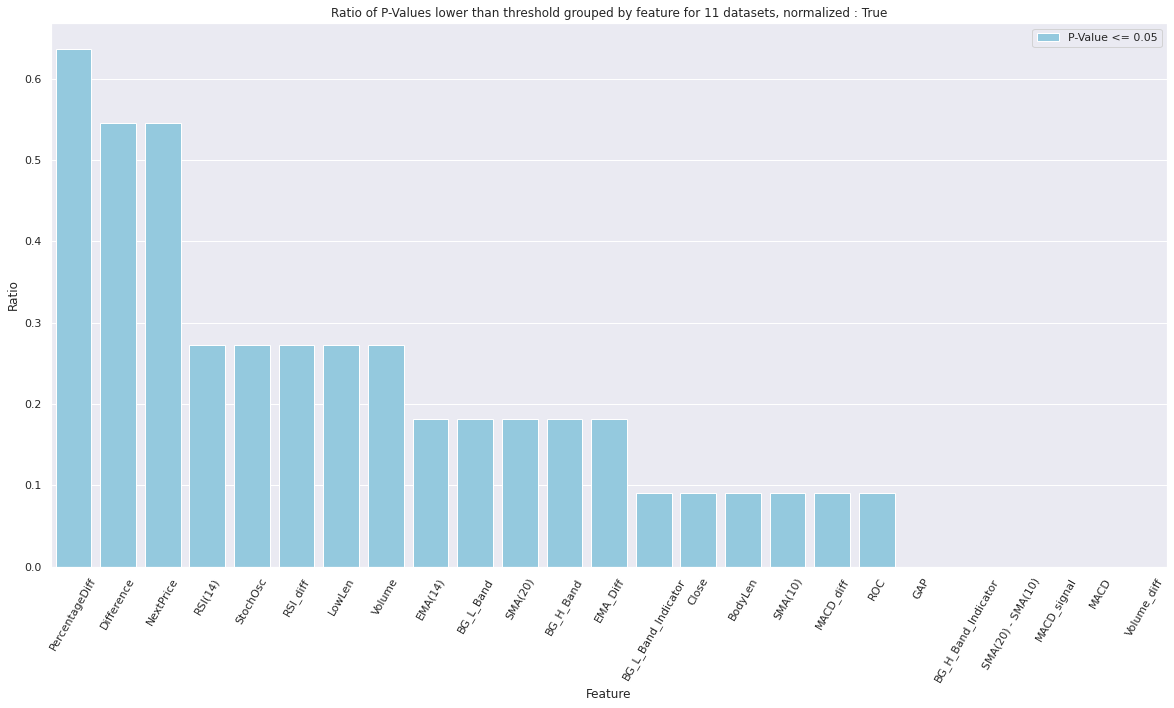

In [32]:
plt.figure(figsize=(20,10))

bar_lower = sns.barplot(x='Feature', y='Lower_Ratio', estimator=sum, data=df, color="skyblue", label=f"P-Value <= {P_THRESH}")
bar_lower.set_xticklabels(bar_lower.get_xticklabels(),rotation=60)
plt.title(f"Ratio of P-Values lower than threshold grouped by feature for {len(df_dict)} datasets, normalized : {NORMALIZE_FEATURES}")
plt.legend(loc='best')
plt.ylabel('Ratio')
plt.show()